#  Demo for Figures in the main text

# 1. Visualization of type average coupling coefficients

This section computes the type average coupling coefficients for each cell types. Then the relationship between the ***primary capsules*** and the ***type capsules*** are illustrated by the heatmap of the type average coupling coefficients and the overall heatmap.

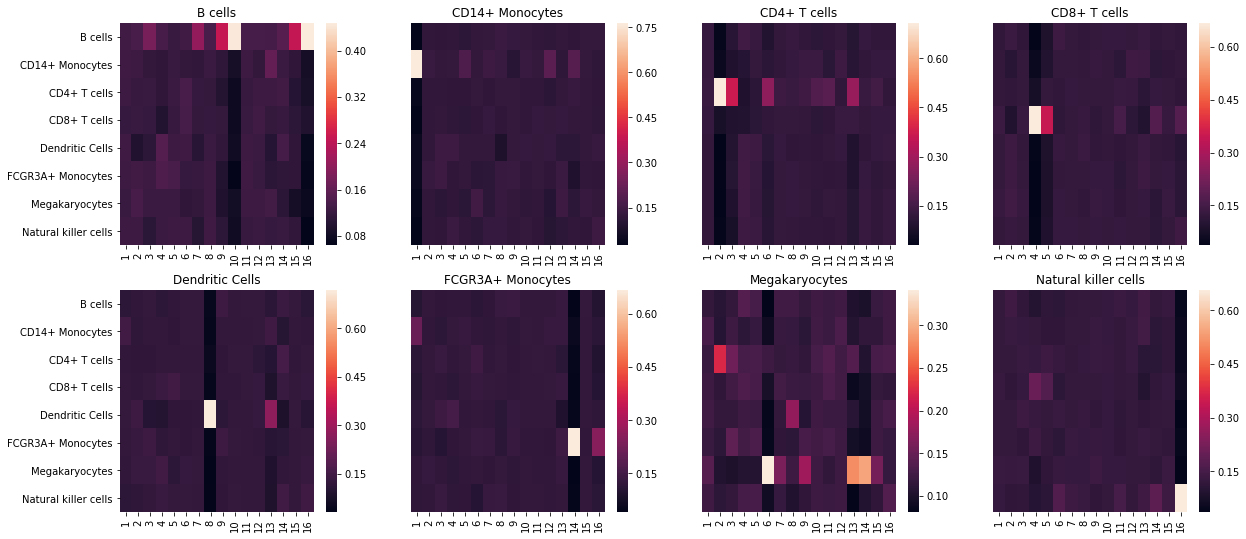

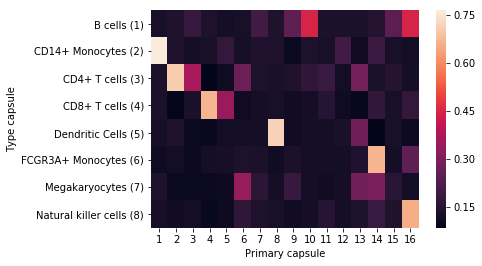

In [14]:
#! -*- coding: utf-8 -*-
# the capsule parts refer to https://github.com/bojone/Capsule and https://kexue.fm/archives/5112

from Visualization_Capsule_Keras import *   #output coupling coefficients
from keras import utils
from keras.models import Model
from keras.layers import *
from keras import backend as K
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame
from sklearn.model_selection import train_test_split

randoms = 30
cell_type = ['B cells','CD14+ Monocytes','CD4+ T cells','CD8+ T cells','Dendritic Cells',
 'FCGR3A+ Monocytes','Megakaryocytes','Natural killer cells']

data = np.load('data/PBMC_data.npy')
labels = np.load('data/PBMC_celltype.npy')

num_classes = 8

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.1, random_state= randoms)
Y_test = y_test
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

z_dim = 16


######################################################################################################################
#scCapsNet

input_size = x_train.shape[1]
x_in = Input(shape=(input_size,))
x = x_in
#scCapsNet -- 1. feature extraction
x1 = Dense(z_dim, activation='relu')(x_in)
x2 = Dense(z_dim, activation='relu')(x_in)
x3 = Dense(z_dim, activation='relu')(x_in)
x4 = Dense(z_dim, activation='relu')(x_in)
x5 = Dense(z_dim, activation='relu')(x_in)
x6 = Dense(z_dim, activation='relu')(x_in)
x7 = Dense(z_dim, activation='relu')(x_in)
x8 = Dense(z_dim, activation='relu')(x_in)
x9 = Dense(z_dim, activation='relu')(x_in)
x10 = Dense(z_dim, activation='relu')(x_in)
x11 = Dense(z_dim, activation='relu')(x_in)
x12 = Dense(z_dim, activation='relu')(x_in)
x13 = Dense(z_dim, activation='relu')(x_in)
x14 = Dense(z_dim, activation='relu')(x_in)
x15 = Dense(z_dim, activation='relu')(x_in)
x16 = Dense(z_dim, activation='relu')(x_in)

encoder1 = Model(x_in, x1)
encoder2 = Model(x_in, x2)
encoder3 = Model(x_in, x3)
encoder4 = Model(x_in, x4)
encoder5 = Model(x_in, x5)
encoder6 = Model(x_in, x6)
encoder7 = Model(x_in, x7)
encoder8 = Model(x_in, x8)
encoder9 = Model(x_in, x9)
encoder10 = Model(x_in, x10)
encoder11 = Model(x_in, x11)
encoder12 = Model(x_in, x12)
encoder13 = Model(x_in, x13)
encoder14 = Model(x_in, x14)
encoder15 = Model(x_in, x15)
encoder16 = Model(x_in, x16)

x = Concatenate()([x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16])
encoder = Model(x_in,x)

#scCapsNet -- 2. capsule networks
x = Reshape((16, z_dim))(x)
capsule = Capsule(num_classes, 16, 3, False)(x)
output = capsule  ##output coupling coefficients

model = Model(inputs=x_in, outputs=output)
model.compile(loss=lambda y_true,y_pred: y_true*K.relu(0.9-y_pred)**2 + 0.25*(1-y_true)*K.relu(y_pred-0.1)**2,
              optimizer='adam',
              metrics=['accuracy'])

#model.summary()

model.load_weights('data/Demo_PBMC.weights')    #load saved weights for demonstration


######################################################################################################################
#calculate the type average coupling coefficients

Y_pred = model.predict(x_test)

coupling_coefficients_value = {}
count = {}
for i in range(len(Y_pred)):
    ind = int(Y_test[i])     #identify cell type
    if ind in coupling_coefficients_value.keys():
        coupling_coefficients_value[ind] = coupling_coefficients_value[ind] + Y_pred[i]   #sum of coupling coefficients for each cell type
        count[ind] = count[ind] + 1   #sample counts for each cell type   
    if ind not in coupling_coefficients_value.keys():
        coupling_coefficients_value[ind] = Y_pred[i]
        count[ind] = 1

total = np.zeros((num_classes,16))

#type average coupling coefficients
plt.figure(figsize=(20,9))
for i in range(num_classes):
    average = coupling_coefficients_value[i]/count[i]   #sum/count = average
    Lindex = i + 1
    plt.subplot(2,4,Lindex)
    plt.title(cell_type[i])
    total[i] = average[i]
    df = DataFrame(np.asmatrix(average),columns=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
    if Lindex==1 or Lindex==5:
        heatmap = sns.heatmap(df, yticklabels=['B cells','CD14+ Monocytes','CD4+ T cells','CD8+ T cells','Dendritic Cells',
 'FCGR3A+ Monocytes','Megakaryocytes','Natural killer cells'])
    else:
        heatmap = sns.heatmap(df,yticklabels=[])
plt.show()

#overall heatmap
cell_type = ['B cells (1)','CD14+ Monocytes (2)','CD4+ T cells (3)','CD8+ T cells (4)','Dendritic Cells (5)',
 'FCGR3A+ Monocytes (6)','Megakaryocytes (7)','Natural killer cells (8)']

plt.figure()
df = DataFrame(np.asmatrix(total),index=cell_type,columns=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
heatmap = sns.heatmap(df)

plt.ylabel('Type capsule', fontsize=10)
plt.xlabel('Primary capsule', fontsize=10)
plt.show()



# 2. Select the cell type associated genes

This section describes how to find the cell type associated genes according to the weight maxtrix between ***input*** and ***primary capsules***. 

(3346, 16)


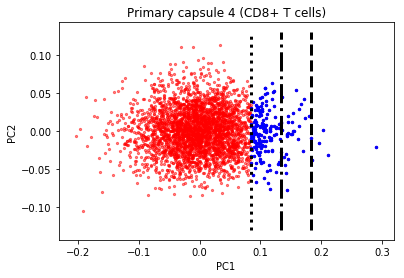

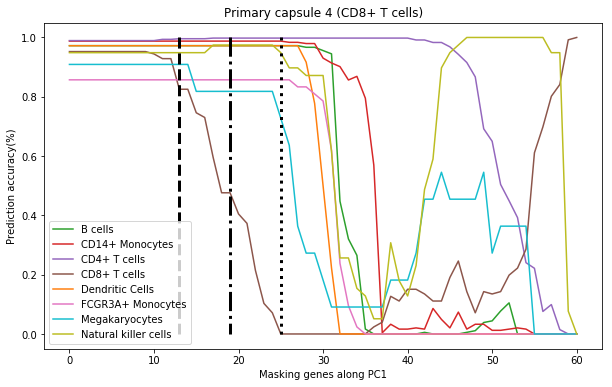

In [24]:
from Capsule_Keras import *  #output for classification

cell_type = ['B cells','CD14+ Monocytes','CD4+ T cells','CD8+ T cells','Dendritic Cells',
 'FCGR3A+ Monocytes','Megakaryocytes','Natural killer cells']
randoms = 30

data = np.load('data/PBMC_data.npy')
labels = np.load('data/PBMC_celltype.npy')

num_classes = 8

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.1, random_state= randoms)
Y_test = y_test
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

z_dim = 16

######################################################################################################################
#scCapsNet

input_size = x_train.shape[1]
x_in = Input(shape=(input_size,))
x = x_in

#scCapsNet -- 1. feature extraction
x1 = Dense(z_dim, activation='relu')(x_in)
x2 = Dense(z_dim, activation='relu')(x_in)
x3 = Dense(z_dim, activation='relu')(x_in)
x4 = Dense(z_dim, activation='relu')(x_in)
x5 = Dense(z_dim, activation='relu')(x_in)
x6 = Dense(z_dim, activation='relu')(x_in)
x7 = Dense(z_dim, activation='relu')(x_in)
x8 = Dense(z_dim, activation='relu')(x_in)
x9 = Dense(z_dim, activation='relu')(x_in)
x10 = Dense(z_dim, activation='relu')(x_in)
x11 = Dense(z_dim, activation='relu')(x_in)
x12 = Dense(z_dim, activation='relu')(x_in)
x13 = Dense(z_dim, activation='relu')(x_in)
x14 = Dense(z_dim, activation='relu')(x_in)
x15 = Dense(z_dim, activation='relu')(x_in)
x16 = Dense(z_dim, activation='relu')(x_in)

encoder1 = Model(x_in, x1)
encoder2 = Model(x_in, x2)
encoder3 = Model(x_in, x3)
encoder4 = Model(x_in, x4)
encoder5 = Model(x_in, x5)
encoder6 = Model(x_in, x6)
encoder7 = Model(x_in, x7)
encoder8 = Model(x_in, x8)
encoder9 = Model(x_in, x9)
encoder10 = Model(x_in, x10)
encoder11 = Model(x_in, x11)
encoder12 = Model(x_in, x12)
encoder13 = Model(x_in, x13)
encoder14 = Model(x_in, x14)
encoder15 = Model(x_in, x15)
encoder16 = Model(x_in, x16)

x = Concatenate()([x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16])

#scCapsNet -- 2. capsule networks
x = Reshape((16, z_dim))(x)
capsule = Capsule(num_classes, 16, 3, False)(x)
output = Lambda(lambda x: K.sqrt(K.sum(K.square(x), 2)), output_shape=(num_classes,))(capsule)  #output for classification

model = Model(inputs=x_in, outputs=output)
model.compile(loss=lambda y_true,y_pred: y_true*K.relu(0.9-y_pred)**2 + 0.25*(1-y_true)*K.relu(y_pred-0.1)**2,
              optimizer='adam',
              metrics=['accuracy'])

#model.summary()
model.load_weights('data/Demo_PBMC.weights')


##############################################################################################
#weight matrix of neural networks
encoder1weight = encoder1.get_weights()
encoder2weight = encoder2.get_weights()
encoder4weight = encoder4.get_weights()
encoder5weight = encoder5.get_weights()
encoder6weight = encoder6.get_weights()
encoder8weight = encoder8.get_weights()
encoder9weight = encoder9.get_weights()
encoder10weight = encoder10.get_weights()
encoder12weight = encoder12.get_weights()
encoder14weight = encoder14.get_weights()
encoder15weight = encoder15.get_weights()
encoder16weight = encoder16.get_weights()

encoder1weight0 = encoder1weight[0]
encoder2weight0 = encoder2weight[0]
encoder4weight0 = encoder4weight[0]
encoder5weight0 = encoder5weight[0]
encoder6weight0 = encoder6weight[0]
encoder8weight0 = encoder8weight[0]
encoder9weight0 = encoder9weight[0]
encoder10weight0 = encoder10weight[0]
encoder12weight0 = encoder12weight[0]
encoder14weight0 = encoder14weight[0]
encoder15weight0 = encoder15weight[0]
encoder16weight0 = encoder16weight[0]

totalweight =encoder4weight0  #select the weight matrix from a specific primary capsule

#use PCA to analyze
pca = PCA(n_components=16)
pca.fit(totalweight)
weightpca = pca.transform(totalweight)
color = [ 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:orange','tab:pink', 'tab:cyan', 'tab:olive']

#################################################################################################
#plot moving line for prediction accuracy along PC

ratio_plot = np.zeros((8,61))
print(weightpca.shape)
difference = (0.2903915 - (-0.205))/60  #approximation maximum-minimum along the PC [0.2903915(maximum), -0.205(minimum)](approximation)
slice_line_pos = (0.2903915 - 0.0845)/difference #0.0845--Manually selected points 

#divide whole domain along PC into 61 points, calculate the the prediction on each point. 
for j in range(61):    
    #1st select genes
    gene_count = 0
    for i in range(3346):
        if weightpca[i, 0] > (0.2903915 - difference*j):
            gene_count = gene_count + 1
            rownum = x_test.shape[0]
            x_test[:, i] = np.zeros(rownum)

    #2nd calculate the accuracy
    Y_pred = model.predict(x_test)
    Y_pred_order = np.argsort(Y_pred,axis=1)
    Y_pred_1 = Y_pred_order[:,7]

    current_type = 0
    total = [0,0,0,0,0,0,0,0]
    correct = [0,0,0,0,0,0,0,0]

    for i in range(x_test.shape[0]):
        index_int = int(Y_test[i])
        if Y_test[i] == Y_pred_1[i]:
            correct[index_int] = correct[index_int] + 1
        total[index_int] = total[index_int] + 1

    prediction_accuracy = [0,0,0,0,0,0,0,0]
    for i in range(len(total)):
        prediction_accuracy[i] = correct[i]/total[i]

    for i in range(len(total)):
        ratio_plot[i,j] = prediction_accuracy[i]


################################################################################################################
#module for mark the selected genes (scatter plots)
removed = [[],[],[]]
for i in range(3346):
    if weightpca[i, 0] > (0.2903915 - difference *13):
        removed[0].append(i)
    if weightpca[i, 0] > (0.2903915 - difference *19) and weightpca[i, 0] <= (0.2903915 - difference *13):
        removed[1].append(i)
    if weightpca[i, 0] > (0.0845) and weightpca[i, 0] <= (0.2903915 - difference *19):
        removed[2].append(i)

plt.scatter(weightpca[:, 0], weightpca[:, 1],color='r', s=5,alpha=0.5)
plt.scatter(weightpca[removed[0], 0], weightpca[removed[0], 1], color = 'b',s=6)
plt.scatter(weightpca[removed[1], 0], weightpca[removed[1], 1], color = 'b',s=6)
plt.scatter(weightpca[removed[2], 0], weightpca[removed[2], 1], color = 'b',s=6)

#position of dotted lines
cut_pos1 = 0.2903915 - difference *13
cut_pos2 = 0.2903915 - difference *19
cut_pos3 = 0.0845

plt.plot([cut_pos1,cut_pos1],[-0.13,0.13], 'k--',linewidth=3.0)
plt.plot([cut_pos2,cut_pos2],[-0.13,0.13], 'k-.',linewidth=3.0)
plt.plot([cut_pos3,cut_pos3],[-0.13,0.13], 'k:',linewidth=3.0)

plt.ylabel('PC2', fontsize=10)
plt.xlabel('PC1', fontsize=10)
plt.title('Primary capsule 4 (CD8+ T cells)')
plt.show()


################################################################################################################
#module for prediction accuracy (line plots)

fig = plt.figure(figsize=(10,6))
#plot the prediction accuracy
for i in range(8):
    plt.plot(ratio_plot[i],  c=color[i], label=cell_type[i])

#plot the vertical lines
plt.plot([13,13],[1.0,0], 'k--',linewidth=3.0)
plt.plot([19,19],[1.0,0], 'k-.',linewidth=3.0)
plt.plot([np.round(slice_line_pos),np.round(slice_line_pos)],[1.0,0], 'k:',linewidth=3.0)

plt.legend(loc='lower left')
plt.xlabel('Masking genes along PC1')
plt.ylabel('Prediction accuracy(%)')
plt.title('Primary capsule 4 (CD8+ T cells)')
plt.show()

# 3. Gene embedding
This section uses the column vectors from weight matrix as the ***embedding (or encoding)*** of the genes. Then the PCA and TSNE are used to analyze the embedding of the genes

10374


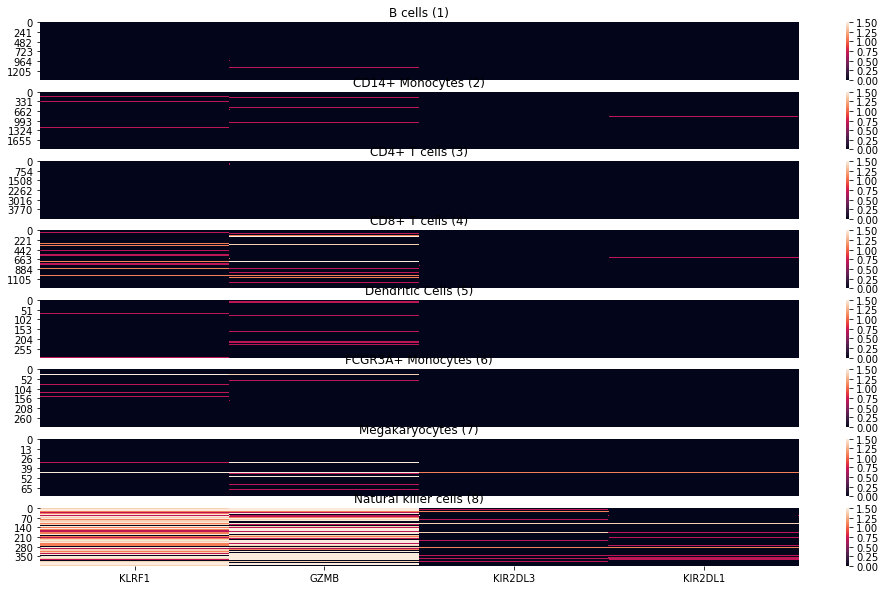

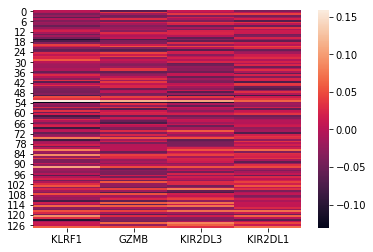

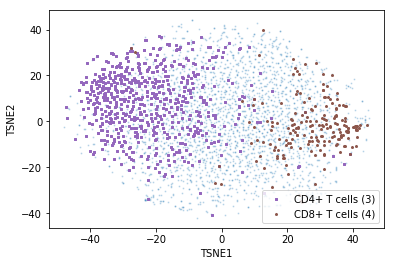

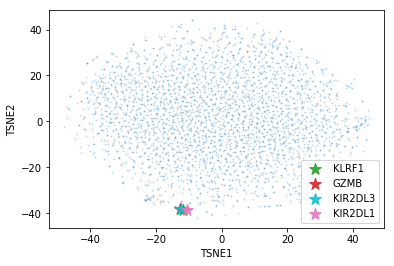

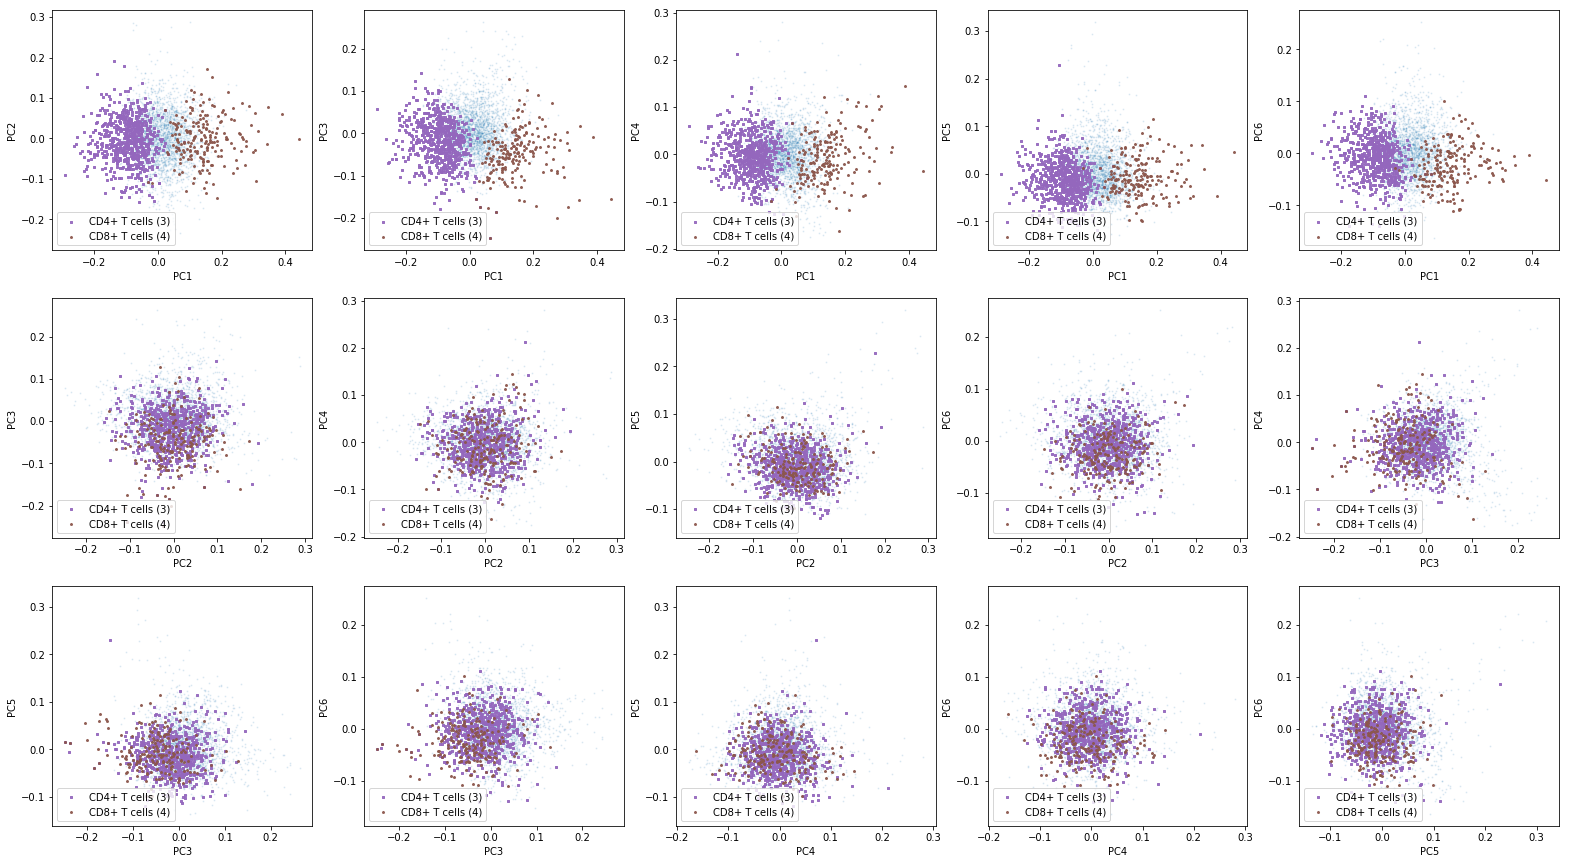

In [17]:
#! -*- coding: utf-8 -*-
# the capsule parts refer to https://github.com/bojone/Capsule and https://kexue.fm/archives/5112


randoms = 30

data = np.load('data/PBMC_data.npy')
labels = np.load('data/PBMC_celltype.npy')

num_classes = 8

#print(type(data))
#print(data.shape)

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.1, random_state= randoms)
Y_test = y_test
Y_train = y_train

###################################################################################################
#input data expressin profile
cell_type_sort_index = [[],[],[],[],[],[],[],[]]
for i in range(len(y_train)):
    cell_type_sort_index[int(y_train[i])].append(i)
type_list = []

for i in range(8):
    type_list.extend(cell_type_sort_index[i])

print(len(type_list))
NK_cluster = np.array([2080,2312,3201,3202])
gene_name = ["KLRF1","GZMB","KIR2DL3","KIR2DL1"]

gene_list = list(NK_cluster-1)
express_matrix = x_train[type_list,:]
express_matrix = express_matrix[:,gene_list]

Lindex = 1
plt.figure(figsize=(17,10))
for i in range(8):
    plt.subplot(8, 1, Lindex)
    express_matrix = x_train[cell_type_sort_index[i], :]
    express_matrix = express_matrix[:, gene_list]
    if i==7:
        df = DataFrame(np.asmatrix(express_matrix), columns=gene_name)
        heatmap = sns.heatmap(df,vmax=1.5)
        plt.title(cell_type[i])
        continue
    heatmap = sns.heatmap(express_matrix,vmax=1.5,xticklabels=False)
    Lindex = Lindex +1
    plt.title(cell_type[i])
plt.show()


#y_train = utils.to_categorical(y_train, num_classes)
#y_test = utils.to_categorical(y_test, num_classes)


'''
###########################################################################################
#TSNE of the input expression data (first 100 Principle components for eliminate noise)

x_t = np.transpose(x_train)
pca = PCA(n_components=100)
pca.fit(x_t)
x_t_pca = pca.transform(x_t)
tsne = TSNE()
x_t_tsne = tsne.fit_transform(x_t_pca)
np.save("D:/data_embedding_pca.npy",x_t_tsne[:,[0,1]])
exit()
'''

#Concatenate column vectors from 8 weight matrix (with each corresponding to a cell type)  
totalweight = np.hstack((encoder10weight0,encoder1weight0,encoder2weight0,encoder4weight0, encoder8weight0,encoder14weight0,encoder6weight0,encoder16weight0))
###################################################################################################
#visualize the Concatenated column vectors of selectd genes
sns.heatmap(np.transpose(totalweight[NK_cluster-1]),xticklabels=gene_name) 
plt.show()

'''
###############################################################################################
#Concatenate column vectors -- PCA and TSNE
pca = PCA(n_components=6)
pca.fit(totalweight)
weightpca = pca.transform(totalweight)
np.save("D:/totalembedding_pca.npy",weightpca[:,[0,1,2,3,4,5]])

tsne = TSNE()
tsne12 = tsne.fit_transform(totalweight)
np.save("D:/totalembedding_tsne.npy",tsne12[:,[0,1]])
'''
#print(totalweight.shape)


#selected genes computed by the model
CD4163total=np.array([2362,1612,521,1429,813,2934,2729,2264,449,993,2522 ,2112 ,2451 ,1941 ,432 ,3156 ,1316 ,503 ,2275 ,640 ,662 ,2746 ,726 ,979 ,495 ,1311 ,3286 ,1099 ,990 ,2420 ,1424 ,1808 ,1445 ,941 ,1844 ,398 ,2722 ,2767 ,582 ,2342 ,31 ,3240 ,2677 ,3152 ,1904 ,980 ,2387 ,3046 ,1498 ,3218 ,957 ,274 ,2236 ,2790 ,2879 ,2276 ,1393 ,1589 ,2242 ,1970 ,1447 ,139 ,2723 ,32 ,548 ,2398 ,2317 ,465 ,1558 ,2361 ,1409 ,2900 ,1579 ,549 ,1502 ,2614 ,203 ,559 ,527 ,1652 ,482 ,740 ,179 ,2690 ,186 ,2399 ,2592 ,457 ,893 ,2014 ,1473 ,552 ,499 ,1624 ,236 ,1053 ,15 ,924 ,1201 ,1000 ,1922 ,1320 ,2732 ,973 ,1042 ,802 ,1045 ,223 ,1562 ,680 ,1679 ,16 ,3320 ,2996 ,2978 ,1312 ,3004 ,2354 ,58 ,1358 ,478 ,3341 ,1884 ,1672 ,3262 ,159 ,2316 ,226 ,1999 ,1694 ,1559 ,2963 ,1370 ,720 ,544 ,1569 ,326 ,1185 ,2683 ,1461 ,806 ,2808 ,3126 ,2770 ,946 ,1423 ,2409 ,824 ,3311 ,1440 ,3168 ,1331 ,3290 ,2576 ,2360 ,1242 ,3086 ,2866 ,1901 ,2453 ,1983 ,2847 ,1643 ,1499 ,2177 ,2062 ,1257 ,1861 ,1500 ,1660 ,2032 ,1204 ,768 ,1295 ,2200 ,1542 ,515 ,911 ,520 ,1427 ,1942 ,2487 ,1860 ,2291 ,1834 ,532 ,1323 ,534 ,1442 ,2216 ,3039 ,1031 ,2600 ,1762 ,347 ,2249 ,1625 ,2158 ,1665 ,1153 ,533 ,3115 ,2648 ,2217 ,2798 ,2704 ,341 ,689 ,2049 ,916 ,190 ,2719 ,1609 ,2332 ,1739 ,2988 ,2930 ,2644 ,3318 ,404 ,3089 ,2579 ,2991 ,2777 ,2509 ,3303 ,1896 ,3224 ,2966 ,2108 ,1183 ,1484 ,91 ,2146 ,2859 ,96 ,22 ,1096 ,1528 ,1408 ,748 ,1690 ,1237 ,1775 ,905 ,2055 ,2323 ,1902 ,2789 ,2348 ,624 ,2135 ,93 ,473 ,1020 ,1925 ,88 ,5 ,663 ,2848 ,1347 ,3140 ,2922 ,1880 ,1028 ,1897 ,3071 ,3333 ,2471 ,1975 ,891 ,1608 ,1368 ,3340 ,2504 ,1116 ,3044 ,2688 ,2415 ,431 ,1996 ,1655 ,2378 ,1115 ,1830 ,2673 ,904 ,3104 ,603 ,2884 ,2801 ,951 ,2976 ,2605 ,942 ,3131 ,1720 ,954 ,761 ,2038 ,2460 ,1800 ,1670 ,741 ,479 ,366 ,282 ,676 ,1565 ,872 ,673 ,1477 ,2005 ,2726 ,2609 ,1177 ,444 ,2102 ,522 ,2758 ,313 ,2140 ,206 ,1258 ,1522 ,240 ,2295 ,2213 ,953 ,1940 ,3065 ,1205 ,41 ,1336 ,540 ,2968 ,2300 ,2110 ,3328 ,1151 ,1455 ,396 ,2530 ,960 ,61 ,1546 ,1006 ,1238 ,2591 ,3088 ,3237 ,779 ,2535 ,706 ,1241 ,643 ,2578 ,3038 ,1865 ,1002 ,3271 ,1957 ,2889 ,456 ,2012 ,335 ,1066 ,2120 ,2246 ,2911 ,2379 ,1519 ,3012 ,1508 ,3092 ,70 ,2560 ,1385 ,930 ,1886 ,1324 ,1815 ,181 ,2534 ,2744 ,1514 ,547 ,2533 ,2220 ,1505 ,1091 ,2949 ,448 ,1907 ,329 ,1837 ,2343 ,2087 ,2937 ,1715 ,2018 ,926 ,810 ,789 ,2742 ,2374 ,2939 ,823 ,245 ,2672 ,3041 ,543 ,302 ,2353 ,3037 ,664 ,1611 ,1987 ,708 ,3336 ,119 ,2256 ,443 ,1929 ,2482 ,1315 ,888 ,2042 ,2837 ,481 ,3030 ,2569 ,1726 ,965 ,2111 ,2109 ,586 ,1011 ,169 ,2321 ,1418 ,2818 ,1432 ,703 ,3153 ,1506 ,2738 ,2917 ,966 ,112 ,674 ,661 ,485 ,152 ,2465 ,3034 ,2685 ,2344 ,106 ,940 ,145 ,1698 ,3031 ,3292 ,1994 ,1086 ,2989 ,1782 ,565 ,1978 ,141 ,2304 ,2431 ,1247 ,877 ,2518 ,2349 ,3047 ,308 ,2178 ,1279 ,3178 ,3132 ,435 ,276 ,2286 ,1723 ,1412 ,672 ,2095 ,1373 ,2356 ,2538 ,595 ,2924 ,2902 ,68 ,2248 ,2653 ,9 ,1472 ,1959 ,23 ,1194 ,64 ,2296 ,238 ,1005 ,2060 ,1202 ,2165 ,490 ,384 ,1731 ,939 ,2629 ,1667 ,1040 ,1452 ,2329 ,2341 ,3055 ,2686 ,1555 ,1544 ,2519 ,1371 ,1718 ,563 ,463 ,2302 ,1121 ,2098 ,1596 ,2334 ,2469 ,2196 ,1459 ,2119 ,2338 ,3005 ,1411 ,1819 ,747 ,155 ,510 ,2714 ,3249 ,1098 ,1228 ,2346 ,1363 ,1305 ,984 ,1765 ,1482 ,927 ,460 ,1335 ,812 ,614 ,1072 ,530 ,2702 ,2516 ,1894 ,2929 ,2893 ,1457 ,77 ,3062 ,3144 ,2322 ,1945 ,1469 ,403 ,3293 ,2826 ,2594 ,1758 ,3159 ,2233 ,976 ,2234 ,1289 ,870 ,1342 ,1551 ,2794 ,3170 ,1687 ,2203 ,2745 ,2730 ,38 ,146 ,2388 ,117 ,3219 ,147 ,932 ,1688 ,545 ,2056 ,2041 ,265 ,895 ,836 ,2948 ,2221 ,1510 ,89 ,241 ,2612 ,985 ,833 ,1577 ,1645 ,351 ,1773 ,609 ,2520 ,229 ,2977 ,1728 ,2692 ,1729 ,631 ,1749 ,1059 ,466 ,1216 ,221 ,3206 ,2172 ,3124 ,2269 ,1574 ,1264 ,1332 ,3146 ,3101 ,2962 ,410 ,1878 ,195 ,2324 ,1664 ,1753 ,42 ,1222 ,1919 ,2953 ,958 ,50,355,1862,2369,2309,1192,2169 ,1583,1671,2088,2883 ,2987,1064 ,80 ,1598])
CD8163total=np.array([486 ,446 ,901 ,2064 ,3184 ,1842 ,728 ,3 ,2076 ,1820 ,1617 ,1943 ,2507 ,3087 ,2641 ,2520 ,1755 ,2861 ,729 ,3075 ,2898 ,650 ,450 ,1482 ,2876 ,772 ,2212 ,653 ,2397 ,411 ,1873 ,865 ,2715 ,755 ,3112 ,3135 ,667 ,1253 ,1628 ,2052 ,246 ,1918 ,2906 ,3094 ,2311 ,501 ,1523 ,1046 ,1893 ,3250 ,1060 ,2904 ,2181 ,3137 ,2267 ,571 ,325 ,1881 ,1069 ,1731 ,2124 ,625 ,1548 ,861 ,468 ,62 ,2796 ,1972 ,46 ,3316 ,2484 ,1351 ,399 ,1149 ,902 ,2776 ,808 ,2734 ,1952 ,1167 ,713 ,536 ,873 ,1083 ,638 ,2566 ,2078 ,2170 ,364 ,922 ,2284 ,777 ,3133 ,1902 ,294 ,2411 ,782 ,2773 ,2282 ,1724 ,774 ,702 ,1325 ,1850 ,2394 ,1518 ,3306 ,2414 ,2657 ,787 ,1534 ,1419 ,618 ,879 ,1863 ,564 ,800 ,86 ,959 ,408 ,426 ,3251 ,2071 ,1939 ,2454 ,539 ,3331 ,1012 ,2120 ,2243 ,1816 ,1386 ,1337 ,2045 ,3220 ,1760 ,3098 ,1908 ,2956 ,383 ,2327 ,2844 ,1070 ,256 ,1007 ,2207 ,111 ,1065 ,13 ,1650 ,1666 ,311 ,2735 ,693 ,461 ,2955 ,150 ,2031 ,2967 ,475 ,1252 ,1063 ,2599 ,75 ,780 ,235 ,989 ,2878 ,2232 ,1543 ,2822 ,272 ,881 ,1348 ,504 ,2840 ,192 ,2010 ,1147 ,2084 ,2167 ,820 ,1903 ,3073 ,321 ,1495 ,2351 ,437 ,3252 ,33 ,2009 ,148 ,2834])
DC163total=np.array([2664 ,251 ,255 ,98 ,2250 ,2844 ,3181 ,1355 ,1388 ,2310 ,350 ,1220 ,1373 ,1069 ,2244 ,2927 ,2912 ,387 ,327 ,711 ,2380 ,2147 ,841 ,2287 ,2756 ,2930 ,248 ,2488 ,2046 ,1482 ,604 ,1799 ,2161 ,545 ,1108 ,1032 ,2252 ,730 ,197 ,886 ,2574 ,200 ,2288 ,603 ,1863 ,243 ,198 ,1864 ,2445 ,1934 ,683 ,658 ,601 ,1912 ,2043 ,1431 ,1211 ,965 ,3250 ,1889 ,29 ,2505 ,1150 ,1653 ,498 ,3116 ,2914 ,1082 ,2897 ,2294 ,3182 ,774 ,2477 ,3275 ,2476 ,2682 ,3260 ,813 ,1778 ,2700 ,1868 ,1095 ,1176 ,2218 ,593 ,502 ,616 ,2917 ,620 ,368 ,1365 ,2181 ,144 ,2732 ,1104 ,991 ,888 ,1622 ,650 ,2754 ,3102 ,639 ,2092 ,2899 ,2784 ,2436 ,193 ,2490 ,2404 ,1337 ,210 ,1062 ,2859 ,1947 ,1359 ,2185 ,2337 ,1084 ,1476 ,2479 ,765 ,1503 ,269 ,3114 ,1147 ,415 ,628 ,3137 ,555 ,3165 ,86 ,1758 ,1511 ,596 ,2494 ,2427 ,2562 ,1779 ,107 ,907 ,2499 ,1568 ,595 ,407 ,3025 ,2666 ,1780 ,309 ,2386 ,1982 ,948 ,297 ,1859 ,1081 ,1808 ,2646 ,230 ,2195 ,2961 ,2906 ,2214 ,1014 ,2462 ,2875 ,2813 ,1459 ,2108 ,220 ,1970 ,501 ,685 ,3273 ,1171 ,913 ,917 ,1054 ,2327 ,655 ,3311 ,1801 ,1658 ,1642 ,569 ,3296 ,2791 ,149 ,3303 ,2838 ,1165 ,3028 ,1083 ,1668 ,218 ,645 ,695 ,1748 ,2565 ,1797 ,2763 ,833 ,2221 ,661 ,1690 ,3214 ,3282 ,2794 ,1246 ,3100 ,2663 ,1929 ,2881 ,580 ,2942 ,2110 ,1956 ,2665 ,257 ,444 ,2564 ,3120 ,18 ,1038 ,321 ,2583 ,3208 ,172 ,2896 ,2135 ,921 ,3283 ,3278 ,1097 ,2779 ,366 ,829 ,1960 ,821 ,1174 ,2198 ,3149 ,1706 ,2007 ,1474 ,2050 ,2458 ,2593 ,1577 ,3079 ,1834 ,59 ,443 ,2616 ,1295 ,1286 ,3113 ,609 ,3176 ,3094 ,2470 ,3244 ,935 ,2802 ,615 ,1346 ,3298 ,2089 ,1839 ,613 ,25 ,1453 ,1300 ,552 ,2830 ,2397 ,2455 ,733 ,3207 ,922 ,1360 ,2271 ,2519 ,1318 ,1133 ,1841 ,515 ,710 ,1529 ,2102 ,1589 ,2058 ,58 ,190 ,2721 ,749 ,1990 ,2757 ,1709 ,2473 ,1314 ,1645 ,2988 ,2281 ,3128 ,1158 ,941 ,590 ,497 ,2103 ,2438 ,2316 ,1005 ,1650 ,1256 ,36 ,2621 ,3333 ,607 ,2960 ,250 ,1857 ,364 ,859 ,1058 ,2668 ,1382 ,113 ,1602 ,3280 ,2667 ,558 ,1269 ,235 ,1437 ,1581 ,3073 ,3274 ,56 ,2032 ,2933 ,1001 ,2418 ,342 ,2381 ,1998 ,611 ,2266 ,3009 ,2639 ,915 ,1327 ,2457 ,87 ,933 ,559 ,771 ,2376 ,1504 ,2937 ,2342 ,660 ,2758 ,1302 ,1444 ,2489 ,3248 ,836 ,34 ,3021 ,3106 ,405 ,2548 ,791 ,460 ,2874 ,2647 ,773 ,2855 ,727 ,2177 ,2980 ,2974 ,1755 ,3018 ,2132 ,298 ,2742 ,3302 ,2885 ,156])
CD14163total =np.array([828 ,213 ,2075 ,967 ,1776 ,3095 ,3278 ,3243 ,1855 ,212 ,2231 ,252 ,1487 ,2485 ,1039 ,1601 ,3024 ,1742 ,1322 ,722 ,1674 ,2394 ,830 ,1921 ,3061 ,1526 ,1210 ,1129 ,320 ,592 ,788 ,1374 ,1954 ,1060 ,487 ,2082 ,1923 ,80 ,1118 ,267 ,1326 ,2871 ,1635 ,1571 ,1512 ,1700 ,2888 ,26 ,470 ,1899 ,1549 ,61 ,2479 ,2637 ,2180 ,1671 ,1008 ,628 ,1908 ,2268 ,3045 ,1553 ,317 ,1002 ,3197 ,36 ,414 ,2910 ,225 ,2363 ,1961 ,3198 ,2963 ,1016 ,2130 ,2101 ,752 ,2594 ,864 ,1441 ,2806 ,656 ,787 ,1476 ,2280 ,1783 ,3070 ,19 ,692 ,2596 ,1433 ,1490 ,214 ,1166 ,1472 ,1218 ,2462 ,1520 ,1351 ,159 ,898 ,2578 ,1006 ,1525 ,1192 ,1435 ,147 ,1854 ,117 ,2320 ,576 ,2011 ,1425 ,2043 ,2957 ,1643 ,1665 ,2517 ,2083 ,85 ,1156 ,2432 ,1688 ,2997 ,2792 ,1972 ,1543 ,1545 ,2854 ,559 ,45 ,744 ,1596 ,1696 ,2145 ,925 ,439 ,2762 ,1081 ,2217 ,3280 ,649 ,653 ,2768 ,2392 ,2058 ,803 ,1262 ,1321 ,972 ,105 ,3026 ,1353 ,160 ,2210 ,2540 ,945 ,1795 ,2710 ,274 ,2274 ,3125 ,2634 ,211 ,2883 ,2733 ,1187 ,1930 ,2804 ,1985 ,2962 ,2023 ,2166 ,202 ,1340 ,2847 ,2610 ,1233 ,1221 ,1887 ,3153 ,2810 ,1327 ,880 ,2931 ,2347 ,2727 ,445 ,1440 ,428 ,772 ,2643 ,3233 ,1413 ,34 ,2379 ,1893 ,297 ,734 ,478 ,650 ,666 ,948 ,855 ,1349 ,2766 ,2572 ,245 ,2853 ,663 ,2629 ,155 ,633 ,1617 ,1256 ,1981 ,1879 ,1249 ,298 ,2552 ,978 ,187 ,2039 ,2834 ,229 ,3217 ,1130 ,2031 ,2030 ,842 ,336 ,277 ,92 ,3167 ,2453 ,1749 ,2284 ,201 ,2464 ,2323 ,810 ,3300 ,2886 ,3048 ,426 ,226 ,266 ,529 ,1023 ,2575 ,3172 ,3118 ,2864 ,2897 ,1979 ,236 ,796 ,737 ,1821 ,2021 ,436 ,3092 ,3321 ,1881 ,2924 ,403 ,567 ,2817 ,1848 ,962 ,3151 ,3275 ,1427 ,980 ,1146 ,1661 ,596 ,1456 ,2113 ,2848 ,2852 ,613 ,1612 ,463 ,3117 ,2473 ,2242 ,1733 ,1515 ,2143 ,2941 ,82 ,3203 ,3161 ,696 ,1495 ,2184 ,1846 ,1102 ,571 ,291 ,832 ,3121 ,1378 ,1986 ,750 ,1140 ,892 ,2542 ,1624 ,562 ,393 ,6 ,847 ,2153 ,533 ,1290 ,739 ,2950 ,2511 ,1554 ,2939 ,2654 ,1935 ,2262 ,2054 ,698 ,303 ,2785 ,220 ,1892])
B163total = np.array([3246 ,840 ,691 ,2554 ,1540 ,1869 ,1359 ,1083 ,1081 ,2556 ,319 ,909 ,249 ,1481 ,830 ,2649 ,1209 ,2845 ,1932 ,947 ,982 ,2932 ,2783 ,1077 ,949 ,392 ,1878 ,2575 ,3332 ,3179 ,1082 ,2623 ,359 ,1191 ,2536 ,3321 ,477 ,3166 ,2856 ,2326 ,1104 ,2002 ,1293 ,268 ,2118 ,2302 ,1030 ,944 ,1789 ,2973 ,1335 ,46 ,1604 ,3122 ,2552 ,418 ,2632 ,2193 ,1271 ,334 ,1136 ,168 ,2681 ,1292 ,2228 ,1337 ,729 ,2279 ,1019 ,2923 ,1252 ,2800 ,1613 ,1246 ,1509 ,165 ,2631 ,1857 ,904 ,629 ,1395 ,3026 ,1627 ,762 ,3207 ,1418 ,2514 ,2751 ,1021 ,573 ,2181 ,1127 ,1121 ,1725 ,167 ,3285 ,492 ,838 ,1044 ,2000 ,199 ,1399 ,1998 ,2650 ,1032 ,3275 ,140 ,1211 ,804 ,3093 ,3032 ,1118 ,2473 ,2253 ,2922 ,1066 ,1495 ,1281 ,2812 ,77 ,660 ,2848 ,3008 ,552 ,2323 ,3284 ,986 ,1459 ,3136 ,1847 ,321 ,797 ,3313 ,679 ,1280 ,2404 ,281 ,3067 ,205 ,951 ,3242 ,1573 ,332 ,653 ,1721 ,1754 ,308 ,254 ,329 ,1912 ,2477 ,2530 ,3148 ,2762 ,1122 ,3131 ,3213 ,2146 ,1219 ,1841 ,971 ,1402 ,3123 ,251 ,315 ,2200 ,636 ,1106 ,285 ,2241 ,1745 ,2986 ,1422 ,1076 ,182 ,2951 ,1896 ,2350 ,2287 ,800 ,2138 ,2765 ,1679 ,2453 ,2617 ,1113 ,1203 ,3190 ,1583 ,654])
CD16163total = np.array([173 ,1003 ,1687 ,3016 ,348 ,1686 ,2334 ,794 ,28 ,1104 ,77 ,1284 ,2206 ,1400 ,2091 ,3209 ,2223 ,3157 ,605 ,146 ,2020 ,266 ,494 ,723 ,678 ,1947 ,2544 ,2858 ,1845 ,1667 ,2516 ,3285 ,3267 ,1988 ,3164 ,1443 ,2946 ,228 ,2691 ,627 ,2655 ,2420 ,2059 ,1927 ,2350 ,3310 ,1608 ,364 ,2393 ,1161 ,589 ,1629 ,2920 ,3192 ,1446 ,3214 ,1678 ,1565 ,691 ,2528 ,11 ,782 ,2574 ,1257 ,1307 ,39 ,3095 ,2957 ,1103 ,1673 ,1033 ,3169 ,2293 ,2795 ,3340 ,1198 ,2190 ,981 ,2475 ,1378 ,3262 ,899 ,3025 ,1011 ,2301 ,1053 ,2697 ,2573 ,932 ,776 ,1978 ,2923 ,1313 ,1128 ,397 ,3001 ,328 ,1440 ,875 ,2006 ,3042 ,1461 ,2809 ,1690 ,669 ,53 ,2557 ,2724 ,57 ,2783 ,930 ,1276 ,330 ,316 ,389 ,2856 ,2565 ,2693 ,3174 ,1630 ,763 ,2455 ,1600 ,1746 ,2442 ,701 ,60 ,2221 ,3154 ,1824 ,2220 ,736 ,2539 ,809 ,2734 ,1830 ,524 ,1340 ,3111 ,744 ,2554 ,2671 ,118 ,2102 ,1890 ,1360 ,1395 ,1604 ,2333 ,1388 ,54 ,2935 ,2009 ,612 ,3322 ,2850 ,344 ,493 ,3054 ,3261 ,291 ,3079 ,1587 ,1701 ,1762 ,1437 ,1951 ,2626 ,874 ,37 ,2330 ,1958 ,2216 ,3342 ,3327 ,1134 ,1397 ,824 ,544 ,3033 ,1682 ,1815 ,2526 ,1699 ,1705 ,2687 ,23 ,808 ,1874 ,1844 ,2860 ,2265 ,2474 ,3235 ,3270 ,617 ,1050 ,988 ,166 ,2537 ,2266 ,2689 ,893 ,2374 ,1173 ,1831 ,1001 ,1697 ,1648 ,1822 ,1594 ,2903 ,372 ,2952 ,3124 ,430 ,2219 ,2197 ,1823 ,315 ,50 ,499 ,2046 ,2149 ,2026 ,137 ,2176 ,998 ,1992 ,868 ,2566 ,1672 ,32 ,957 ,3176 ,492 ,2478 ,1206 ,815 ,1813 ,2047 ,1896 ,869 ,2193 ,27 ,831 ,1771 ,480])
NK163total =np.array([173 ,266 ,3184 ,1033 ,1971 ,2492 ,132 ,2080 ,3276 ,2981 ,3201 ,1926 ,723 ,1820 ,3095 ,612 ,2312 ,3202 ,806 ,3307 ,557 ,462 ,1686 ,1197 ,258 ,1874 ,2077 ,826 ,3252 ,1813 ,3059 ,912 ,2163 ,2788 ,546 ,2856 ,454 ,3117 ,2488 ,3105 ,1450 ,863 ,1325 ,3274 ,977 ,2442 ,2427 ,2631 ,1548 ,2983 ,3152 ,2552 ,1471 ,2722 ,3078 ,315 ,29 ,1337 ,493 ,2425 ,1067 ,1293 ,2915 ,1419 ,2209 ,548 ,2606 ,1550 ,1207 ,800 ,2590 ,789 ,207 ,839 ,3244 ,2507 ,2009 ,188 ,2873 ,1081 ,1687 ,3022 ,2862 ,340 ,970 ,226 ,3262 ,1524 ,2823 ,319 ,1700 ,3286 ,1875 ,1585 ,633 ,2449 ,1814 ,2951 ,3164 ,1110 ,2079 ,3246])
MK163total=np.array([817 ,816 ,1259 ,1043 ,2938 ,2057 ,705 ,1915 ,3237 ,1654 ,1286 ,579 ,1036 ,2260 ,1535 ,1049 ,464 ,120 ,811 ,920 ,1669 ,2601 ,783 ,3006 ,2641 ,1181 ,2979 ,721 ,1953 ,669 ,416 ,1678 ,735 ,1012 ,1323 ,1451 ,278 ,375 ,2429 ,284 ,1550 ,2926 ,2761 ,2651 ,2928 ,2880 ,1320 ,825 ,2541 ,2953 ,396 ,664 ,127 ,2564 ,2605 ,3262 ,805 ,1903 ,1257 ,193 ,849 ,1922 ,2896 ,1519 ,2081 ,1009 ,3146 ,2326 ,1518 ,848 ,17 ,349 ,2466 ,1011 ,2045 ,2463 ,330 ,2324 ,2446 ,1142 ,2139 ,2372 ,725 ,3056 ,1583 ,3219 ,2900 ,1029 ,1812 ,2613 ,818 ,3090 ,1094 ,2947 ,819 ,3265 ,151 ,1985 ,2270 ,153 ,1299 ,2996 ,1814 ,301 ,1867 ,3061 ,1940 ,1101 ,1920 ,1359 ,2368 ,1402 ,2902 ,2030 ,3288 ,3085 ,3264 ,2540 ,1186 ,2361 ,3175 ,2158 ,650 ,2709 ,2430 ,194 ,2126 ,3280 ,3188 ,3345 ,307 ,1833 ,1731 ,1015 ,649 ,363 ,1143 ,2451 ,446 ,2076 ,2096 ,1475 ,220 ,531 ,78 ,3153 ,1317 ,1187 ,1785 ,935 ,2520 ,1987 ,4 ,1759 ,2542 ,1042 ,2665 ,2639 ,2570 ,2508 ,1750 ,283 ,1218 ,2582 ,2404 ,1942 ,293 ,2098 ,2394 ,59 ,1534 ,465 ,2877 ,1354 ,2763 ,3077 ,695 ,2384 ,2949 ,3245 ,2303 ,1449 ,1810 ,2647 ,1075 ,1096 ,1305 ,2094 ,133 ,1250 ,639 ,2941 ,2671 ,371 ,85 ,2089 ,1911 ,428 ,606 ,2321 ,1546 ,719 ,215 ,2585 ,1952 ,310 ,504 ,2636 ,3010 ,1873 ,1405 ,381 ,484 ,481 ,1562 ,3210 ,186 ,741 ,1766 ,879 ,901 ,181 ,821 ,1092 ,596 ,486 ,565 ,1791 ,1706 ,685 ,1544 ,1401 ,1051 ,152 ,377 ,2729 ,785 ,176 ,3223 ,2155 ,1192 ,2066 ,2010 ,145 ,845 ,159 ,2458 ,1002 ,2390 ,2977 ,762 ,1016 ,295 ,1752 ,1139 ,2207 ,2438 ,2022 ,1981 ,1111 ,1410 ,2085 ,1712 ,3266 ,842 ,788 ,704 ,1780 ,389 ,1855 ,223 ,1614 ,1692 ,347 ,2986 ,3174 ,528 ,623 ,3024 ,525 ,27 ,2543 ,2857 ,2179 ,10 ,2680 ,866 ,941 ,2453 ,2284 ,3226 ,2840 ,3195 ,738 ,752 ,2417 ,2360 ,338 ,16 ,632 ,2660 ,1680 ,991 ,3339 ,1406 ,2772 ,2449 ,933 ,731 ,1988 ,875 ,798 ,2186 ,86 ,652 ,2012 ,333 ,2245 ,312 ,421 ,2696 ,3221 ,88 ,871 ,2526 ,2810 ,2678 ,2915 ,586 ,1362 ,544 ,1931 ,2529 ,1105 ,1141 ,233 ,51 ,1357 ,1954 ,1523 ,2023 ,2190 ,1743 ,2829 ,2739 ,91 ,1513 ,994 ,147 ,2987 ,1235 ,1809 ,810 ,3125 ,907 ,2927 ,2160 ,796 ,316 ,1128 ,538 ,561 ,1268 ,303 ,3160 ,1754 ,884 ,1792 ,2599 ,415 ,1797 ,557 ,808 ,3057 ,3263 ,654 ,495 ,772 ,1717 ,1565 ,3247 ,926 ,2141 ,137 ,3041 ,1088 ,1506 ,1983 ,2657 ,1377 ,1292 ,1234 ,257 ,2113 ,1559 ,583 ,2389 ,1361 ,1448 ,1188 ,912 ,15 ,2753 ,422 ,618 ,3300 ,2711 ,471 ,1213 ,1779 ,1820 ,1605 ,2223 ,1610 ,887 ,1588 ,334 ,1935 ,665 ,667 ,240 ,2311 ,1393 ,952 ,1897 ,1722 ,1923 ,2787 ,1364 ,2779 ,1138 ,345 ,3222 ,1255 ,448 ,1951 ,1995 ,2793 ,1807 ,1880 ,2954 ,529 ,1022 ,2653 ,2327 ,1601 ,1444 ,116 ,1502 ,505 ,2330 ,2169 ,3296 ,2138 ,1028 ,1063 ,530 ,57 ,1741 ,2610 ,1486 ,112 ,1280 ,3308 ,1657 ,2125 ,911 ,916 ,604 ,1251 ,2548 ,1388 ,1479 ,178 ,182 ,454 ,2376 ,2211 ,2439 ,2751 ,1176 ,2861 ,2329 ,2142 ,1509 ,149 ,2581 ,48 ,844 ,1906 ,53 ,2850 ,2275 ,558 ,1325 ,580 ,324 ,716 ,1452 ,807 ,774 ,238 ,3298 ,3230 ,81 ,1064 ,2163 ,2258 ,2688 ,1468 ,3020 ,1349 ,1464 ,2975 ,897 ,459 ,3143 ,802 ,3228 ,2272 ,3036 ,1745 ,1679 ,2461 ,1283 ,927 ,180 ,2154 ,1135 ,889 ,3068 ,519 ,1282 ,1046 ,1445 ,2059 ,1975 ,118 ,3242 ,3004 ,734 ,3012 ,353 ,100 ,1070 ,1383 ,1861 ,2604 ,1504 ,527 ,3105 ,3035 ,539 ,2054 ,1434 ,1619 ,2626 ,1938 ,1207 ,158 ,2821 ,208 ,1123 ,3261 ,2189 ,769 ,1965 ,281 ,391 ,2379 ,1959 ,642 ,2084 ,878 ,1275 ,1840 ,3301 ,1881 ,1802 ,1684 ,2367 ,2027 ,2239 ,2352 ,406 ,1331 ,1817 ,1409 ,2878 ,508 ,9 ,423 ,2495 ,472 ,515 ,728 ,3292 ,280 ,3318 ,2277 ,996 ,1332 ,1974 ,2578 ,572 ,2213 ,111 ,2942 ,117 ,424 ,241 ,1838 ,2208 ,76 ,479 ,1916 ,2882 ,2341 ,2007 ,2072 ,939 ,189 ,2289 ,2000 ,425 ,2035 ,749 ,1436 ,390 ,2597 ,1026])

gene_index = [B163total,CD14163total,CD4163total,CD8163total,DC163total,CD16163total,MK163total,NK163total]


############################################################################################
#plot the TSNE Concatenate column vectors

marker = ['*', '+', 's', 'p', 'x', 'D', 'o', '>']
color = [ 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:orange','tab:pink', 'tab:cyan', 'tab:olive']

NK_gene_name = ["KLRF1","GZMB","KIR2DL3","KIR2DL1"]

coordinates_tsne = np.load("data/totalembedding_tsne.npy")
plt.scatter(coordinates_tsne[:, 0], coordinates_tsne[:, 1], s=1, alpha=0.2)

#plot TSNE of Concatenate column vectors (selected genes from two different cell types)
for i in range(8):
    if i != 2 and i != 3: #and i!=1 and i!=5:
        continue
    select = list(gene_index[i]-1)
    plt.scatter(coordinates_tsne[select, 0], coordinates_tsne[select, 1], marker=marker[i],color = color[i],s=5 , label=cell_type[i])

plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.legend(loc='lower right')
plt.show()

#plot TSNE of Concatenate column vectors (selected genes)
plt.scatter(coordinates_tsne[:, 0], coordinates_tsne[:, 1], s=1, alpha=0.2)
index = 0
marker = ['*', '>', 's', 'p', 'x', 'D', 'o']
color = [ 'tab:green', 'tab:red', 'tab:cyan','tab:pink', 'tab:olive', 'tab:purple', 'tab:brown', 'tab:orange']
for i in NK_cluster:
    plt.scatter(coordinates_tsne[i-1, 0], coordinates_tsne[i-1, 1], marker= '*',color = color[index],s=150 , label=NK_gene_name[index],alpha=0.9)
    index = index + 1

plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.legend(loc='lower right')
plt.show()

############################################################################################
#plot PCA of Concatenate column vectors (selected genes from two different cell types)
coordinates_tsne = np.load("data/totalembedding_pca.npy")
color = [ 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:orange','tab:pink', 'tab:cyan', 'tab:olive']
Lindex = 1
plt.figure(figsize=(27,15))
for out in range(6):
    for inner in range(6):
        if out>=inner:
            continue
        #print(out,inner,Lindex)
        plt.subplot(3, 5, Lindex)
        plt.scatter(coordinates_tsne[:, out], coordinates_tsne[:, inner], s=1, alpha=0.1)
        for i in range(8):
            if i != 2 and i != 3: #i!=1 and i!=5:
                continue
            select = list(gene_index[i]-1)
            plt.scatter(coordinates_tsne[select, out], coordinates_tsne[select, inner], marker=marker[i],color = color[i],s=5,alpha=0.9,label= cell_type[i])
        out_label = out+1
        inner_label = inner + 1
        plt.xlabel('PC'+str(out_label))
        plt.ylabel('PC'+str(inner_label))
        #print(out, inner, Lindex)
        Lindex = Lindex + 1
        plt.legend(loc='lower left')

plt.show()
             


# 4. the misclassification due to the masking of the cell type associted genes

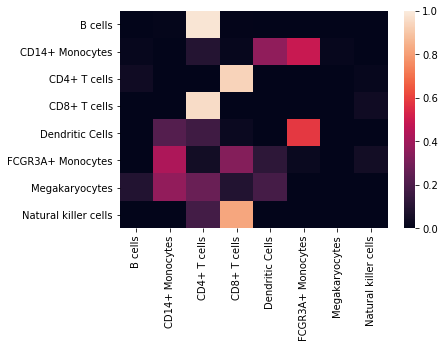

In [23]:


cell_type = ['B cells','CD14+ Monocytes','CD4+ T cells','CD8+ T cells','Dendritic Cells',
 'FCGR3A+ Monocytes','Megakaryocytes','Natural killer cells']
randoms = 30

data = np.load('data/PBMC_data.npy')
labels = np.load('data/PBMC_celltype.npy')

num_classes = 8

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.1, random_state= randoms)
Y_test = y_test
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

z_dim = 16

#PCA for column vectors for weight matrix 
pcaB = PCA(n_components=2)
pcaB.fit(encoder10weight0)
weightpcaB = pcaB.transform(encoder10weight0)

pcaCD14 = PCA(n_components=2)
pcaCD14.fit(encoder1weight0)
weightpcaCD14 = pcaCD14.transform(encoder1weight0)

pcaCD4 = PCA(n_components=2)
pcaCD4.fit(encoder2weight0)
weightpcaCD4 = pcaCD4.transform(encoder2weight0)

pcaCD8 = PCA(n_components=2)
pcaCD8.fit(encoder4weight0)
weightpcaCD8 = pcaCD8.transform(encoder4weight0)

pcaDC = PCA(n_components=2)
pcaDC.fit(encoder8weight0)
weightpcaDC = pcaDC.transform(encoder8weight0)

pcaFmono = PCA(n_components=2)
pcaFmono.fit(encoder14weight0)
weightpcaFmono = pcaFmono.transform(encoder14weight0)

pcaMega = PCA(n_components=2)
pcaMega.fit(encoder6weight0)
weightpcaMega = pcaMega.transform(encoder6weight0)

pcaNK = PCA(n_components=2)
pcaNK.fit(encoder16weight0)
weightpcaNK = pcaNK.transform(encoder16weight0)

weight = [weightpcaB, weightpcaCD14,weightpcaCD4,weightpcaCD8,weightpcaDC,weightpcaFmono,weightpcaMega,weightpcaNK]

removed1 = []
removed2 = []
removed3 = []
removed4 = []
removed5 = []
removed6 = []
removed7 = []
removed8 = []

#Along PC to discard(mask) the cell type associated genes
for i in range(3346):
    if weightpcaCD4[i, 0] < -0.046:
        removed3.append(i)
    if weightpcaCD8[i, 0] >0.0845:
        removed4.append(i)
    if weightpcaDC[i, 0] > 0.045:
        removed5.append(i)
    if weightpcaNK[i, 0] > 0.0805:
        removed8.append(i)
    if weightpcaCD14[i, 0] < -0.067:
        removed2.append(i)
    if weightpcaB[i, 0] > 0.06:
        removed1.append(i)
    if weightpcaFmono[i, 0] > 0.0587:
        removed6.append(i)
    if weightpcaMega[i, 1] > 0.0266:
        removed7.append(i)
remove = [removed1,removed2,removed3,removed4,removed5,removed6,removed7,removed8]


#re-run the model without the cell type associated genes
for j in range(8):
    x_test_masking_genes = np.copy(x_test)
    for i in remove[j]:
        rownum = x_test.shape[0]
        x_test_masking_genes[:, i] = np.zeros(rownum)

    Y_pred = model.predict(x_test_masking_genes)
    Y_pred_order = np.argsort(Y_pred, axis=1)
    Y_pred_1 = Y_pred_order[:, 7]

    current_type = j
    total = [0, 0, 0, 0, 0, 0, 0, 0]
    mismatch = [0, 0, 0, 0, 0, 0, 0, 0]
    for i in range(x_test.shape[0]):
        index_int = int(Y_test[i])
        if Y_test[i] == current_type:
            mismatch[int(Y_pred_1[i])] = mismatch[int(Y_pred_1[i])] + 1
        total[index_int] = total[index_int] + 1

    for i in range(len(total)):
        mismatch[i] = mismatch[i]/total[current_type]

    if j == 0:
        all_mismatch = np.asarray(mismatch)
    else:
        all_mismatch = np.vstack((all_mismatch,np.asarray(mismatch)))

df = DataFrame(np.asmatrix(all_mismatch),index=cell_type,columns=cell_type)
heatmap = sns.heatmap(df,xticklabels = cell_type,vmax=1,vmin=0)
plt.show()